In [1]:
import quandl
import pandas as pd
import seaborn as sns
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime
import math
import quandl
import seaborn as sns
import sys
import pandas_datareader.data as web
from statsmodels.graphics.tsaplots import plot_acf
import datetime as dt
from dateutil.relativedelta import relativedelta

/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def Z_score(data):
    # not including the current observation
    std = data.iloc[:-1].std()
    mean = data.iloc[:-1].mean()
    Z = (data[-1:] - mean)/std
    return Z

In [3]:
def color_negative_red(value):
    """
      Colors elements in a dateframe
      green if positive and red if
      negative. Does not color NaN
      values.
      """

    if value < 0:
        color = 'red'
    elif value > 0:
        color = 'green'
    else:
        color = 'black'

    return 'color: %s' % color

# Sentiment analysis (Futures only)
- sp500
- gold
- dollar
- Bitcoin (Not option data)


Z score for net positions (1 and 3 years) and change in position (1 month and 3 months).



In [5]:
#data import

gold_tmp = quandl.get("CFTC/088691_F_L_ALL", authtoken="6rNSyTM5R4g7_B7XSyQW")
sp500_tmp = quandl.get("CFTC/13874A_F_L_ALL_NT", authtoken="6rNSyTM5R4g7_B7XSyQW")
dxy_tmp = quandl.get("CFTC/098662_F_L_ALL", authtoken="6rNSyTM5R4g7_B7XSyQW")
bitcoin_tmp = quandl.get("CFTC/133741_F_L_ALL", authtoken="6rNSyTM5R4g7_B7XSyQW")
bonds_tmp = quandl.get("CFTC/020601_FO_L_ALL", authtoken="6rNSyTM5R4g7_B7XSyQW")
crude_tmp = quandl.get("CFTC/067651_F_L_ALL", authtoken="6rNSyTM5R4g7_B7XSyQW")
silver_tmp = quandl.get("CFTC/084691_F_L_ALL", authtoken="6rNSyTM5R4g7_B7XSyQW")
coco_tmp = quandl.get("CFTC/073732_F_L_ALL", authtoken="6rNSyTM5R4g7_B7XSyQW")

In [6]:
asset_names = ['Gold','Silver', 'SP500','Bonds' , 'DXY', 'Bitcoin', 'Crude Oil', 'Cocoa']

assets = [gold_tmp,silver_tmp,sp500_tmp,bonds_tmp , dxy_tmp, bitcoin_tmp, crude_tmp, coco_tmp]

In [7]:
for asset in assets:
    ## BASED ON KANG ET AL
    try:
        asset['Net Position'] = asset['Noncommercial Long'] - asset['Noncommercial Short']
        asset['scld NP'] = asset['Net Position']/ asset['Open Interest']
    except:
        asset['Net Position'] = asset['Non Commercial Longs'] - asset['Non Commercial Shorts']
        asset['scld NP'] = asset['Net Position']
    
    asset['1 Yr Z Score'] = asset['scld NP'].rolling(52).apply(lambda x: Z_score(x),raw=False)
    asset['3 Yr Z Score'] = asset['scld NP'].rolling(3 * 52).apply(lambda x: Z_score(x),raw=False) 
    asset['1 Month Change'] = asset['scld NP'].diff(4)/asset['scld NP'].shift(4)
    asset['3 Month Change'] = asset['scld NP'].diff(3*4)/asset['scld NP'].shift(3*4)

In [8]:
TOTAL_ASSETS = None

for asset in assets:
    
    TOTAL_ASSETS = pd.concat([TOTAL_ASSETS, asset.tail(1)], axis = 0)
    
TOTAL_ASSETS['Asset'] = asset_names
TOTAL_ASSETS.set_index(['Asset'], inplace=True, drop=True)

compact = ['1 Yr Z Score', '3 Yr Z Score', '1 Month Change', '3 Month Change']
TOTAL_ASSETS = TOTAL_ASSETS[compact]

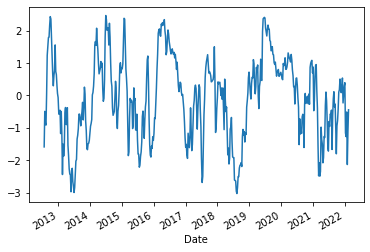

In [9]:
assets[0]['1 Yr Z Score'].tail(500).plot();

## Display Results

In [10]:
th_props = [
  ('font-size', '16px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


# Set CSS properties for td elements in dataframe
td_props = [('font-size', '16px'), ('text-align', 'center')]

# Set table styles
styles = [
    dict(selector="th", props=th_props),
    dict(selector="td", props=td_props)
]

cm_low_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(TOTAL_ASSETS.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
cm_high_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(TOTAL_ASSETS.columns), as_cmap=True)

TOTAL_ASSETS_VIEW = (TOTAL_ASSETS.style
    .applymap(color_negative_red, subset=['1 Yr Z Score', '3 Yr Z Score', '1 Month Change', '3 Month Change'])
    #.background_gradient(axis = 0 ,subset = ['DSSP', 'HIDI'],cmap=cm_high_good)
    #.background_gradient(axis = 0 ,subset = ['VRANK', 'MRANK','CRANK', 'ST'],cmap=cm_low_good)
    .set_caption('Speculator Positioning')
    .format({'1 Month Change': "{:.1%}",'3 Month Change': "{:.1%}", '1 Yr Z Score': "{:.2f}", '3 Yr Z Score': "{:.2f}"})
    .set_table_styles(styles))

# Returns, Realized and Implied Volatility

In [11]:
#Prices

GOLD_price_tmp = yf.download('GLD')
SP500_price_tmp = yf.download('SPY')
DXY_price_tmp = yf.download('DX-Y.NYB')
BIT_price_tmp = yf.download('BTC-USD')
TLT_price_tmp = yf.download('TLT')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [12]:
GOLD_price = pd.DataFrame(GOLD_price_tmp['Close'])
SP500_price = pd.DataFrame(SP500_price_tmp['Close'])
DXY_price = pd.DataFrame(DXY_price_tmp['Close'])
BIT_price = pd.DataFrame(BIT_price_tmp['Close'])
TLT_price = pd.DataFrame(TLT_price_tmp['Close'])

prices = [GOLD_price,SP500_price,TLT_price,DXY_price, BIT_price ]
price_names = ['Gold', 'SP500', 'TLT' ,'DXY', 'Bitcoin']

In [13]:
imp_vol = pd.DataFrame()
imp_vol['Asset'] = ['Gold', 'SP500', 'Bonds','DXY', 'Bitcoin']
imp_vol['ImpVol'] = np.nan 

tickers = ['GLD', 'SPY','TLT' ,'UUP']
month_delta = 1

for i in range(len(tickers)):
    try:
        price_ind = yf.download(tickers[i],start='2020-01-01', progress = False, threads = False)
        stock = yf.Ticker(tickers[i])
        option_dates = stock.options
        date = dt.datetime.now()
        date += relativedelta(months=month_delta) 
        expiry_one_month = min(option_dates, key=lambda x:abs(dt.datetime.strptime(x, "%Y-%M-%d")-date))
        current_price = float(price_ind['Close'].tail(1))
        
        calls = stock.option_chain(expiry_one_month).calls
        puts = stock.option_chain(expiry_one_month).puts
        
        #ATM Skew
        ATM_put = puts[puts['strike'] == min(puts['strike'], key=lambda x:abs(x-current_price))]
        ATM_call = calls[calls['strike'] == min(calls['strike'], key=lambda x:abs(x-current_price))]
        ATM_skew = float(ATM_put['impliedVolatility']) - float(ATM_call['impliedVolatility']) 
        
        imp_vol.loc[i,"ImpVol"] = float(ATM_put['impliedVolatility'])
        
    except:
        print("ERROR! INDEX: ", i, ', TICKER: ', tickers[i])



In [14]:
for price in prices:
    price['1 Month Return'] = price['Close'].pct_change(20)
    price['3 Month Return'] = price['Close'].pct_change(60)
    price['Volatility'] = price['Close'].pct_change().rolling(21).std()*(252**0.5)
    price['3 year Volatility Z-Score'] = price['Volatility'].rolling(3 * 52).apply(lambda x: Z_score(x),raw=False) 


PRICES = None

for price in prices:
    
    PRICES = pd.concat([PRICES, price.tail(1)], axis = 0)
    
PRICES['Asset'] = asset_names
compact_1 = ['Asset', '1 Month Return', '3 Month Return', 'Volatility', '3 year Volatility Z-Score']
PRICES = PRICES[compact_1]
PRICES.set_index(['Asset'], inplace=True, drop=True)

PRICES = pd.merge(PRICES, imp_vol, how="left", on=['Asset'])
PRICES['Implied Vol Premium'] = PRICES['ImpVol'] - PRICES['Volatility']

ValueError: Length of values (8) does not match length of index (5)

In [15]:
PRICES

,Close,1 Month Return,3 Month Return,Volatility,3 year Volatility Z-Score
Date,,,,,
2022-02-24,179.005005,0.054273,0.074331,0.129445,0.346574
2022-02-24,420.570007,-0.029558,-0.094770,0.220439,1.974520
2022-02-24,137.690002,-0.020000,-0.077886,0.160043,0.553223
2022-02-24,97.196999,0.007327,0.008896,0.070732,2.264129
2022-02-24,36464.230469,-0.121362,-0.282335,0.618842,1.016185


In [16]:
th_props = [
  ('font-size', '16px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


# Set CSS properties for td elements in dataframe
td_props = [('font-size', '16px'), ('text-align', 'center')]

# Set table styles
styles = [
    dict(selector="th", props=th_props),
    dict(selector="td", props=td_props)
]


cm_low_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(PRICES.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
cm_high_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(PRICES.columns), as_cmap=True)

PRICES_VIEW = (PRICES.style
    .applymap(color_negative_red, subset=['1 Month Return', '3 Month Return', 'Volatility', '3 year Volatility Z-Score', 'ImpVol', 'Implied Vol Premium'])
    .set_caption('Asset Metrics')
    .format({'1 Month Return': "{:.1%}",'3 Month Return': "{:.1%}", 'Volatility': "{:.1%}", '3 year Volatility Z-Score': "{:.2f}", 
            'ImpVol': "{:.1%}",'Implied Vol Premium': "{:.1%}" })
    .set_table_styles(styles))

## View metrics

In [17]:
PRICES_VIEW

KeyError: "['ImpVol', 'Implied Vol Premium'] not in index"

In [18]:
TOTAL_ASSETS_VIEW

,1 Yr Z Score,3 Yr Z Score,1 Month Change,3 Month Change
Asset,,,,
Gold,-0.44,-0.29,6.2%,-8.7%
Silver,-1.24,-0.75,-24.8%,-44.0%
SP500,-1.48,-0.16,-58.3%,-69.7%
Bonds,1.11,1.00,-19.4%,2402.1%
DXY,1.08,1.04,-4.7%,5.1%
Bitcoin,1.75,2.63,-57.8%,81.2%
Crude Oil,-1.84,-1.65,-12.5%,-18.4%
Cocoa,1.42,1.21,62.2%,180.7%


In [65]:
def AHL_signal(data, lookback = [63,42,21]):

    short  = data.ewm(span=lookback[0]).mean() - data.ewm(span=4*lookback[0]).mean()
    medium = data.ewm(span=lookback[1]).mean() - data.ewm(span=4*lookback[1]).mean()
    long = data.ewm(span=lookback[2]).mean() - data.ewm(span=4*lookback[2]).mean()

    #vol = data.pct_change(1).rolling(63).std()
    vol = data.rolling(63).std()

    short_scld = short/vol
    medium_scld = medium/vol
    long_scld = long/vol

    short_norm = short_scld/short_scld.rolling(252).std()
    medium_norm = medium_scld/medium_scld.rolling(252).std()
    long_norm = long_scld/long_scld.rolling(252).std()

    short_sig = (short_norm * np.exp((-short_norm**2)/4))/0.89
    medium_sig = (medium_norm * np.exp((-medium_norm**2)/4))/0.89
    long_sig = (long_norm * np.exp((-long_norm**2)/4))/0.89

    short_sig = short_sig.dropna()
    medium_sig = medium_sig.dropna()
    long_sig = long_sig.dropna()

    comb_signal = (short_sig + medium_sig + long_sig)/3
    
    return(comb_signal)

In [66]:
trend_df = pd.DataFrame()
tickers = ['GLD', 'SPY','EEM', 'TLT', 'DBC', 'DBA', 'USO']

for tick in tickers:
 
    price_tmp = yf.download(tick)
    price_tmp = price_tmp['Close']
    price_df = pd.DataFrame(price_tmp)
    price_df.columns = [tick]
    trend_df = pd.concat([trend_df,price_df ], axis = 1)
    
    
trend_df = trend_df.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [26]:
lookback = [21,31,63]

vol_lookback = max(lookback)
vol = trend_df.rolling(vol_lookback).std()

look_back_dict = {}
df_signals = pd.DataFrame()
for look in lookback:
    trend_tmp = trend_df.ewm(span=look).mean() - trend_df.ewm(span=4*look).mean()
    scld_trend = trend_tmp/vol
    trend_norm = scld_trend/scld_trend.rolling(252).std()
    trend_sig = (trend_norm * np.exp((-trend_norm**2)/4))/0.89
    trend_sig = trend_sig.dropna()
    look_back_dict[look] = trend_sig
    df_signals = df_signals.add(trend_sig, fill_value=0)

df_signals = df_signals/len(lookback)



In [27]:
df_signals.resample('W').last().tail(5)

,GLD,SPY,EEM,TLT,DBC,DBA,USO
Date,,,,,,,
2022-01-30,0.644432,0.175560,-0.778398,-0.513557,0.746559,0.021539,0.788900
2022-02-06,0.531681,0.180829,-0.774273,-0.564484,0.743861,0.012487,0.763729
2022-02-13,0.828634,0.154451,-0.771143,-0.646603,0.769980,0.029739,0.774475
2022-02-20,0.922334,0.019617,-0.848426,-0.682727,0.809067,0.064874,0.813693
2022-02-27,0.866264,-0.081724,-0.888749,-0.685222,0.809950,0.088877,0.818786
